<a href="https://colab.research.google.com/github/jeromecamilleri/reseauElectrique/blob/main/Simu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

interactive(children=(IntSlider(value=5000, description='Nb noeuds', max=5050, min=10, step=10), Output()), _d…

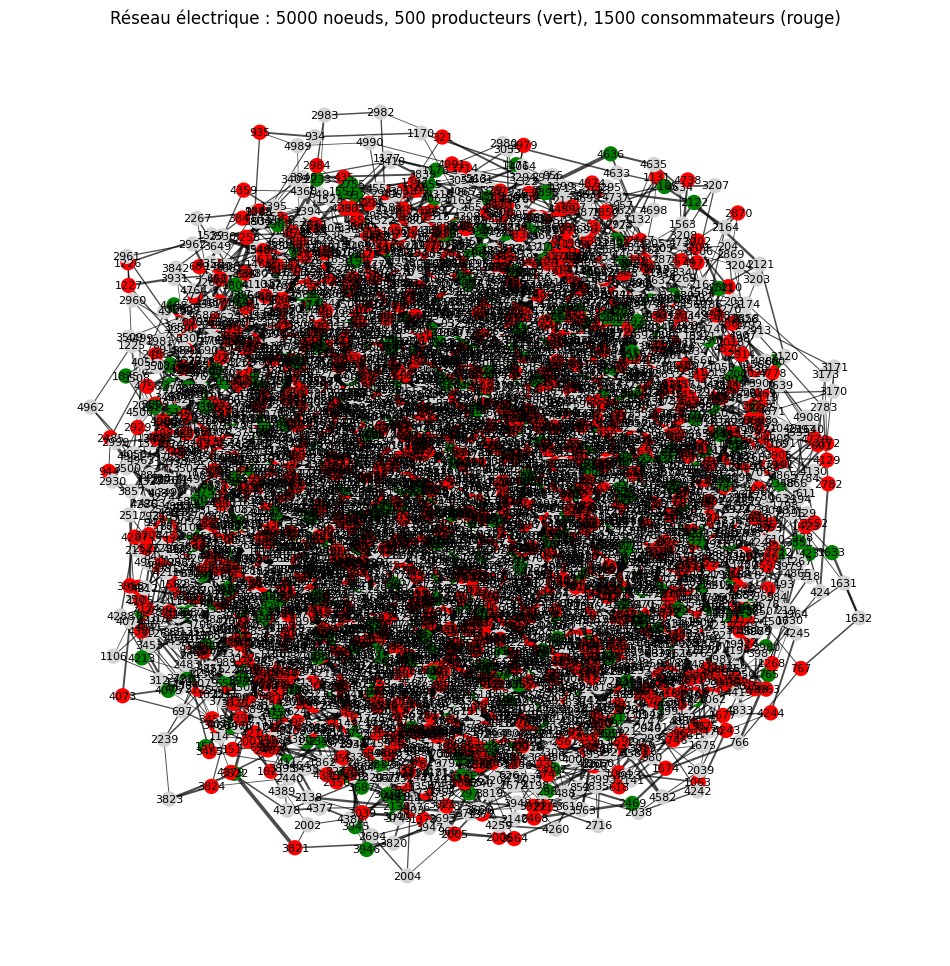

<function __main__.simulate_network(N)>

In [7]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

def simulate_network(N):
    np.random.seed(42)

    prod_count = max(1, int(0.1 * N))   # 10% producteurs
    cons_count = max(1, int(0.3 * N))   # 30% consommateurs

    producers = np.random.choice(N, prod_count, replace=False)
    remaining_nodes = [n for n in range(N) if n not in producers]
    consumers = np.random.choice(remaining_nodes, cons_count, replace=False)

    I = np.zeros(N)
    for c in consumers:
        I[c] = 50
    for p in producers:
        I[p] = -50 * (cons_count / prod_count)

    connexions_par_noeud = 3 if N > 3 else max(1, N - 1)

    A = np.zeros((N, N))

    # Chaîne simple pour garantir connexion
    for i in range(N - 1):
        A[i, i + 1] = -1
        A[i + 1, i] = -1

    # Connexions aléatoires supplémentaires
    for i in range(N):
        current_degree = np.sum(A[i] != 0)
        while current_degree < connexions_par_noeud:
            j = np.random.randint(0, N)
            if j != i and A[i, j] == 0:
                A[i, j] = -1
                A[j, i] = -1
                current_degree += 1

    for i in range(N):
        A[i, i] = -np.sum(A[i, :])

    prod_indices = producers
    other_indices = [i for i in range(N) if i not in prod_indices]

    U_prod_value = 230
    U_p = np.full(prod_count, U_prod_value)

    A_oo = A[np.ix_(other_indices, other_indices)]
    A_op = A[np.ix_(other_indices, prod_indices)]
    I_o = I[other_indices]

    b = I_o - A_op @ U_p
    U_o = np.linalg.solve(A_oo, b)

    U = np.zeros(N)
    U[prod_indices] = U_p
    U[other_indices] = U_o

    edges = []
    edge_weights = []
    for i in range(N):
        for j in range(i + 1, N):
            if A[i, j] != 0:
                I_ij = U[i] - U[j]
                edges.append((i + 1, j + 1))
                edge_weights.append(abs(I_ij))

    # Graph
    G = nx.Graph()
    G.add_nodes_from(range(1, N + 1))
    G.add_edges_from(edges)

    colors = []
    for node in range(1, N + 1):
        if node - 1 in producers:
            colors.append('green')
        elif node - 1 in consumers:
            colors.append('red')
        else:
            colors.append('lightgray')

    pos = nx.spring_layout(G, seed=42)

    min_width = 0.5
    max_width = 3.0
    w_min = min(edge_weights)
    w_max = max(edge_weights)
    edge_widths = [min_width + (max_width - min_width) * (w - w_min) / (w_max - w_min) if w_max > w_min else min_width for w in edge_weights]

    plt.figure(figsize=(12, 12))
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=100)
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(f"Réseau électrique : {N} noeuds, {prod_count} producteurs (vert), {cons_count} consommateurs (rouge)")
    plt.axis('off')
    plt.show()

interact(simulate_network, N=IntSlider(min=10, max=5050, step=10, value=5000, description="Nb noeuds"))
